# Mapping reference to Hh anti-IL10R Visium slides with Cell2location

From original C2L tutorial: https://cell2location.readthedocs.io/en/latest/notebooks/cell2location_tutorial.html

## Loading packages <a class="anchor" id="Loading-packages"></a>

In [2]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl
import pandas as pd

import cell2location

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text for PDFs

Global seed set to 0
/opt/conda/envs/cell2loc_env/lib/python3.7/site-packages/pytorch_lightning/utilities/warnings.py:54: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  "pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6"
/opt/conda/envs/cell2loc_env/lib/python3.7/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [3]:
# defining useful function
def select_slide(adata, s, s_col='Sanger_ID'):
    r""" Select data for one slide from the spatial anndata object.
    
    :param adata: Anndata object with multiple spatial samples
    :param s: name of selected sample
    :param s_col: column in adata.obs listing sample name for each location
    """
    
    slide = adata[adata.obs[s_col].isin([s]), :]
    s_keys = list(slide.uns['spatial'].keys())
    s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]

    slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}
    
    return slide

First, let's define where we save the results of our analysis:

In [4]:
# Set paths to data and results used through the document:
sp_data_folder = '/lustre/scratch126/cellgen/team205/rb29/mice-gut.TCRtg/mouseST_C2L/data/'
results_folder = '/lustre/scratch126/cellgen/team205/rb29/mice-gut.TCRtg/mouseST_C2L/models'

# create paths and names to results folders for reference regression and cell2location models
ref_run_name = f'{results_folder}/reference_signatures'
run_name = f'{results_folder}/cell2location_map_HHantiIl10r_tissueDetQCed'

## Loading Visium and scRNA-seq reference data <a class="anchor" id="Loading-Visium-and-scRNA-seq-reference-data"></a>

In [4]:
adata_vis=sc.read(sp_data_folder+'mouseST_all_tissueDect_QCed.h5ad')
# adata_vis.obs['sample'] = list(adata_vis.uns['spatial'].keys())[0]

In [5]:
adata_vis.obs['sample'].unique()

['1A_Hh.only', '1B_Hh.anti_IL10r', '2A_Hh.only', '2B_Hh.anti_IL10r', '3A_Hh.only', '3B_Hh.anti_IL10r', '4A_Hh.only', '4B_Hh.anti_IL10r']
Categories (8, object): ['1A_Hh.only', '1B_Hh.anti_IL10r', '2A_Hh.only', '2B_Hh.anti_IL10r', '3A_Hh.only', '3B_Hh.anti_IL10r', '4A_Hh.only', '4B_Hh.anti_IL10r']

In [6]:
adata_vis.var

,feature_types,genome,SYMBOL,mt,n_cells_by_counts-1A_Hh.only,mean_counts-1A_Hh.only,log1p_mean_counts-1A_Hh.only,pct_dropout_by_counts-1A_Hh.only,total_counts-1A_Hh.only,log1p_total_counts-1A_Hh.only,...,log1p_mean_counts-4A_Hh.only,pct_dropout_by_counts-4A_Hh.only,total_counts-4A_Hh.only,log1p_total_counts-4A_Hh.only,n_cells_by_counts-4B_Hh.anti_IL10r,mean_counts-4B_Hh.anti_IL10r,log1p_mean_counts-4B_Hh.anti_IL10r,pct_dropout_by_counts-4B_Hh.anti_IL10r,total_counts-4B_Hh.anti_IL10r,log1p_total_counts-4B_Hh.anti_IL10r
ENSEMBL,,,,,,,,,,,,,,,,,,,,,
ENSMUSG00000051951,Gene Expression,mm10,Xkr4,False,3,0.001046,0.001046,99.895361,3.0,1.386294,...,0.000255,99.974477,1.0,0.693147,4,0.001183,0.001183,99.881657,4.0,1.609438
ENSMUSG00000089699,Gene Expression,mm10,Gm1992,False,9,0.003139,0.003134,99.686083,9.0,2.302585,...,0.000765,99.923430,3.0,1.386294,2,0.000592,0.000592,99.940828,2.0,1.098612
ENSMUSG00000102331,Gene Expression,mm10,Gm19938,False,4,0.001395,0.001394,99.860481,4.0,1.609438,...,0.000765,99.923430,3.0,1.386294,2,0.000592,0.000592,99.940828,2.0,1.098612
ENSMUSG00000102343,Gene Expression,mm10,Gm37381,False,0,0.000000,0.000000,100.000000,0.0,0.000000,...,0.000000,100.000000,0.0,0.000000,0,0.000000,0.000000,100.000000,0.0,0.000000
ENSMUSG00000025900,Gene Expression,mm10,Rp1,False,0,0.000000,0.000000,100.000000,0.0,0.000000,...,0.000000,100.000000,0.0,0.000000,0,0.000000,0.000000,100.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000095523,Gene Expression,mm10,AC124606.1,False,0,0.000000,0.000000,100.000000,0.0,0.000000,...,0.000000,100.000000,0.0,0.000000,0,0.000000,0.000000,100.000000,0.0,0.000000
ENSMUSG00000095475,Gene Expression,mm10,AC133095.2,False,0,0.000000,0.000000,100.000000,0.0,0.000000,...,0.000000,100.000000,0.0,0.000000,0,0.000000,0.000000,100.000000,0.0,0.000000
ENSMUSG00000094855,Gene Expression,mm10,AC133095.1,False,0,0.000000,0.000000,100.000000,0.0,0.000000,...,0.000000,100.000000,0.0,0.000000,0,0.000000,0.000000,100.000000,0.0,0.000000


<div class="alert alert-info">
<b>Note!</b>
    
Here we rename genes to ENSEMBL ID for correct matching between single cell and spatial data - so you can ignore the scanpy suggestion to call `.var_names_make_unique`.
</div>

In [6]:
#adata_vis.var['SYMBOL'] = adata_vis.var_names
#adata_vis.var.set_index('gene_ids', drop=True, inplace=True)

In [7]:
adata_vis.var['mt'].unique()

array([False])

You can still plot gene expression by name using standard scanpy functions as follows: 
```python
sc.pl.spatial(color='PTPRC', gene_symbols='SYMBOL', ...)
```

<div class="alert alert-info">
<b>Note!</b>
    
Mitochondia-encoded genes (gene names start with prefix mt- or MT-) are irrelevant for spatial mapping because their expression represents technical artifacts in the single cell and nucleus data rather than biological abundance of mitochondria. Yet these genes compose 15-40% of mRNA in each location. Hence, to avoid mapping artifacts we strongly recommend removing mitochondrial genes.
</div>

In [8]:
# find mitochondria-encoded (MT) genes
#adata_vis.var['mt'] = [gene.startswith('mt-') for gene in adata_vis.var['SYMBOL']]
    
# remove MT genes for spatial mapping (keeping their counts in the object)
adata_vis.obsm['mt'] = adata_vis[:, adata_vis.var['mt'].values].X.toarray()
adata_vis = adata_vis[:, ~adata_vis.var['mt'].values]

## Cell2location: spatial mapping <a class="anchor" id="Cell2location:-spatial-mapping"></a>

<div class="alert alert-block alert-message">
<b>Find shared genes and prepare anndata.</b>
Subset both anndata and reference signatures:
</div>

In [9]:
### Read inf_aver from csv
inf_aver=pd.read_csv("/lustre/scratch126/cellgen/team205/rb29/mice-gut.TCRtg/mouseST_C2L/20230516_info_aver.csv", index_col='gene_ids-0')

In [10]:
inf_aver

,Basophil,CD4.memory,DC1.Cd8+Xcr1+,DC.Il1b_high.Cd103+,DC.Il1b_high.Cd103+Sirpa+,DC.Il1b_low.Cd103-Sirpa+,DC.Sirpa+Cd81+,DC.prolif.,Endothelial.cells,Enteric_neurons,...,Prolif-Tregs,Stem,TA,Th17,cTregs,eMBCs,eTregs,gdTCs.Th17,pDCs,pre-GC.BCs
gene_ids-0,,,,,,,,,,,,,,,,,,,,,
ENSMUSG00000025902,0.005945,0.004345,0.002499,0.003357,0.004163,0.003835,0.004283,0.004632,1.067723,0.000312,...,0.006023,0.001062,0.000817,0.004235,0.002671,0.001945,0.002744,0.004243,0.003433,0.002377
ENSMUSG00000033845,0.193644,0.099569,0.476598,0.489200,0.294325,0.248132,0.281440,0.765813,0.124210,0.076705,...,0.812437,1.769867,1.648953,0.233555,0.232336,0.413259,0.260958,0.175003,0.274985,3.460516
ENSMUSG00000025903,0.098422,0.062413,0.344164,0.221287,0.190022,0.153230,0.155799,0.452727,0.116566,0.000290,...,0.333119,0.783253,0.747714,0.164903,0.141249,0.257298,0.180920,0.150686,0.162863,1.156816
ENSMUSG00000033813,0.005707,0.356234,1.179716,0.795668,0.695342,0.919209,1.209904,1.688650,0.325160,0.120512,...,1.844277,0.580456,0.421663,0.555418,0.469462,0.899309,0.524267,0.609560,0.712396,5.850386
ENSMUSG00000002459,0.006098,0.004572,0.002246,0.003084,0.004199,0.003955,0.004447,0.004529,0.002363,0.406863,...,0.004950,0.001130,0.000860,0.004079,0.002757,0.002183,0.002833,0.004638,0.003287,0.002636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000031358,0.005817,0.023035,0.163502,0.091849,0.110608,0.079784,0.105994,0.390614,0.049655,0.054235,...,0.452607,0.282811,0.211607,0.128949,0.039091,0.117416,0.039545,0.063795,0.163158,0.713505
ENSMUSG00000031355,0.006250,0.004227,0.034250,0.059503,0.101197,0.196970,0.037474,0.125610,0.004723,0.335483,...,0.058849,0.002561,0.000883,0.004498,0.002795,0.042614,0.003029,0.050951,0.066573,0.158838
ENSMUSG00000031354,0.005624,0.004527,0.002713,0.003674,0.004147,0.003764,0.004324,0.004594,0.002688,0.002102,...,0.005392,0.001351,0.000830,0.004615,0.002649,0.010615,0.002901,0.004441,0.003825,0.002513


In [11]:
adata_vis_all = adata_vis.copy()

In [12]:
adata_vis_all.obs["Conditions"].value_counts()

Hh_anti-Il10r    11602
Hh_only          11190
Name: Conditions, dtype: int64

In [13]:
### Run separately for Hh_anti-Il10r !!!

In [14]:
adata_vis=adata_vis_all[adata_vis_all.obs["Conditions"]=="Hh_anti-Il10r"]

In [15]:
adata_vis

View of AnnData object with n_obs × n_vars = 11602 × 32272
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'Sanger_ID', 'library_id', 'Slide_ID', 'Slide', 'Capture_area', 'Mouse', 'Conditions', 'n_counts'
    var: 'feature_types', 'genome', 'SYMBOL', 'mt', 'n_cells_by_counts-1A_Hh.only', 'mean_counts-1A_Hh.only', 'log1p_mean_counts-1A_Hh.only', 'pct_dropout_by_counts-1A_Hh.only', 'total_counts-1A_Hh.only', 'log1p_total_counts-1A_Hh.only', 'n_cells_by_counts-1B_Hh.anti_IL10r', 'mean_counts-1B_Hh.anti_IL10r', 'log1p_mean_counts-1B_Hh.anti_IL10r', 'pct_dropout_by_counts-1B_Hh.anti_IL10r', 'total_counts-1B_Hh.anti_IL10r', 'log1p_total_counts-1B_Hh.anti_IL10r', 'n_cells_by_counts-2A_Hh.only', 'mean_counts-2A_Hh.only', 'log1p_mean_counts-2A_Hh.only', 'pct_dropout_by

In [16]:
adata_vis.var_names

Index(['ENSMUSG00000051951', 'ENSMUSG00000089699', 'ENSMUSG00000102331',
       'ENSMUSG00000102343', 'ENSMUSG00000025900', 'ENSMUSG00000025902',
       'ENSMUSG00000104238', 'ENSMUSG00000104328', 'ENSMUSG00000033845',
       'ENSMUSG00000025903',
       ...
       'ENSMUSG00000096550', 'ENSMUSG00000094172', 'ENSMUSG00000094887',
       'ENSMUSG00000091585', 'ENSMUSG00000095763', 'ENSMUSG00000095523',
       'ENSMUSG00000095475', 'ENSMUSG00000094855', 'ENSMUSG00000095019',
       'ENSMUSG00000095041'],
      dtype='object', name='ENSEMBL', length=32272)

In [17]:
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata_vis.var_names, inf_aver.index)
adata_vis = adata_vis[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=adata_vis, batch_key="Sanger_ID")

<div class="alert alert-info">
<b> Important </b>
    
To use cell2location spatial mapping model, you need to specify 2 user-provided hyperparameters (`N_cells_per_location` and `detection_alpha`) - for detailed guidance on setting these hyperparameters and their impact see [the flow diagram and the note](https://github.com/BayraktarLab/cell2location/blob/master/docs/images/Note_on_selecting_hyperparameters.pdf).
</div>

**Choosing hyperparameter `N_cells_per_location`!**

It is useful to adapt the expected cell abundance `N_cells_per_location` to every tissue</b>. This value can be estimated from paired histology images and as described in the note above. Change the value presented in this tutorial (`N_cells_per_location=30`) to the value observed in your your tissue.

**Choosing hyperparameter `detection_alpha`!**

To improve accuracy & sensitivity on datasets with large technical variability in RNA detection sensitivity within the slide/batch - you need to relax regularisation of per-location normalisation (use `detection_alpha=20`). High technical variability in RNA detection sensitivity is present in your sample when you observe the spatial distribution of total RNA count per location that doesn't match expected cell numbers based on histological examination. 

We initially opted for high regularisation (`detection_alpha=200`) as a default because the mouse brain & human lymph node datasets used in our paper have low technical effects and using high regularisation strenght improves consistencly between total estimated cell abundance per location and the nuclei count quantified from histology ([Fig S8F in cell2location paper](https://static-content.springer.com/esm/art%3A10.1038%2Fs41587-021-01139-4/MediaObjects/41587_2021_1139_MOESM1_ESM.pdf)). However, in many collaborations, we see that Visium experiments on human tissues suffer from technical effects. This motivates the new default value of `detection_alpha=20` and the recommendation of testing both settings on your data (`detection_alpha=20` and `detection_alpha=200`).

In [18]:
# create and train the model
mod = cell2location.models.Cell2location(
    adata_vis, cell_state_df=inf_aver, 
    # the expected average cell abundance: tissue-dependent 
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=30,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection:
    detection_alpha=20
) 
mod.view_anndata_setup()

Anndata setup with scvi-tools version 0.19.0.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'Sanger_ID',
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   4   │
│         n_cells          │ 11602 │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 11926 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                       batch State Registry                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃    Categories    ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Sanger_ID'] │ Mus_Tcel13255054 │          0          │
│                        │ Mus_Tcel13255056 │          1          │
│                        │ Mus_Tcel13290869 │          2          │
│                        │ Mus_Tcel13290871 │          3          │
└────────────────────────┴──────────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

<div class="alert alert-block alert-message">
<b>Training cell2location:</b>
</div>

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/conda/envs/cell2loc_env/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:105: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/envs/cell2loc_env/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:1896: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Epoch 30000/30000: 100%|██████████████████████| 30000/30000 [52:56<00:00,  9.37it/s, v_num=1, elbo_train=1.04e+8]

`Trainer.fit` stopped: `max_epochs=30000` reached.


Epoch 30000/30000: 100%|██████████████████████| 30000/30000 [52:56<00:00,  9.44it/s, v_num=1, elbo_train=1.04e+8]


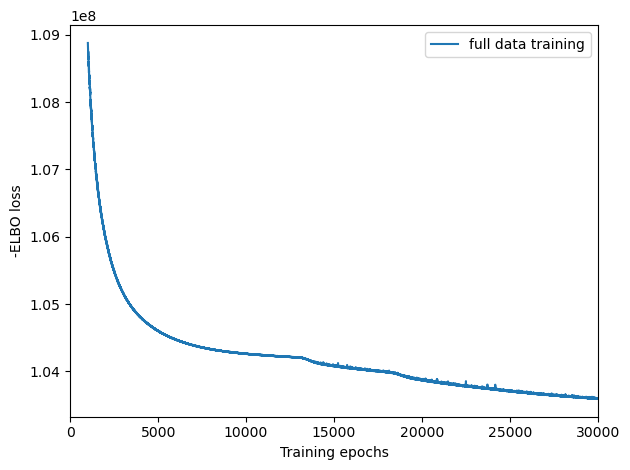

In [19]:
mod.train(max_epochs=30000, 
          # train using full data (batch_size=None)
          batch_size=None, 
          # use all data points in training because 
          # we need to estimate cell abundance at all locations
          train_size=1,
          use_gpu=True,
         )

# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=['full data training']);

<div class="alert alert-block alert-message">
<b>Exporting estimated posterior distributions of cell abundance and saving results:</b>
</div>

In [20]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_vis = mod.export_posterior(
    adata_vis, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs, 'use_gpu': True}
)

# Save model
mod.save(f"{run_name}_Hh_antiIl10r", overwrite=True)

# mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)

# Save anndata object with results
adata_file = f"{run_name}_Hh_antiIl10r.h5ad"
adata_vis.write(adata_file)
adata_file

Sampling global variables, sample: 100%|███████████████████████████████████████| 999/999 [00:20<00:00, 49.29it/s]


'/lustre/scratch126/cellgen/team205/rb29/mice-gut.TCRtg/mouseST_C2L/models/cell2location_map_HHantiIl10r_tissueDetQCed_Hh_antiIl10r.h5ad'

In [23]:
adata_vis

AnnData object with n_obs × n_vars = 11602 × 11926
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'Sanger_ID', 'library_id', 'Slide_ID', 'Slide', 'Capture_area', 'Mouse', 'Conditions', 'n_counts', '_indices', '_scvi_batch', '_scvi_labels'
    var: 'feature_types', 'genome', 'SYMBOL', 'mt', 'n_cells_by_counts-1A_Hh.only', 'mean_counts-1A_Hh.only', 'log1p_mean_counts-1A_Hh.only', 'pct_dropout_by_counts-1A_Hh.only', 'total_counts-1A_Hh.only', 'log1p_total_counts-1A_Hh.only', 'n_cells_by_counts-1B_Hh.anti_IL10r', 'mean_counts-1B_Hh.anti_IL10r', 'log1p_mean_counts-1B_Hh.anti_IL10r', 'pct_dropout_by_counts-1B_Hh.anti_IL10r', 'total_counts-1B_Hh.anti_IL10r', 'log1p_total_counts-1B_Hh.anti_IL10r', 'n_cells_by_counts-2A_Hh.only', 'mean_counts-2A_Hh.only', 'log1p_mean_

In [25]:
#The model and output h5ad can be loaded later like this:

adata_file = f"{run_name}_Hh_antiIl10r.h5ad"
adata_vis = sc.read_h5ad(adata_file)
mod = cell2location.models.Cell2location.load(f"{run_name}_Hh_antiIl10r", adata_vis)


INFO     File                                                                                                      
         /lustre/scratch126/cellgen/team205/rb29/mice-gut.TCRtg/mouseST_C2L/models/cell2location_map_HHantiIl10r_ti
         ssueDetQCed_Hh_antiIl10r/model.pt already downloaded                                                      


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/conda/envs/cell2loc_env/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:105: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/envs/cell2loc_env/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:1896: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Epoch 1/30000:   0%|                               | 1/30000 [00:00<53:35,  9.33it/s, v_num=1, elbo_train=1.9e+8]

`Trainer.fit` stopped: `max_steps=1` reached.


Epoch 1/30000:   0%|                               | 1/30000 [00:00<56:13,  8.89it/s, v_num=1, elbo_train=1.9e+8]


In [26]:
adata_vis = mod.export_posterior(
    adata_vis, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs, 'use_gpu': True}
)


Sampling global variables, sample: 100%|███████████████████████████████████████| 999/999 [00:20<00:00, 48.94it/s]


<div class="alert alert-block alert-message">
<b>Assessing mapping quality.</b>
Examine reconstruction accuracy to assess if there are any issues with mapping.
The plot should be roughly diagonal, strong deviations will signal problems that need to be investigated.
</div>

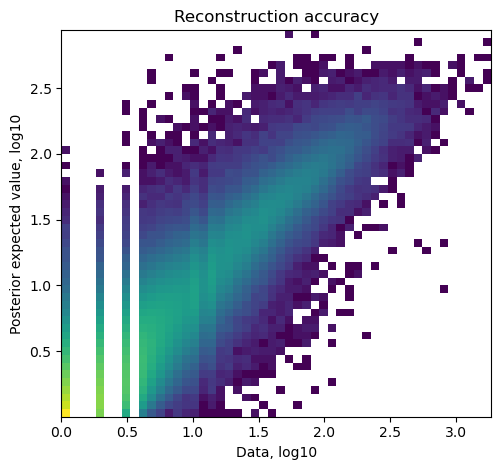

In [27]:
mod.plot_QC()

When intergrating multiple spatial batches and when working with datasets that have substantial variation of detected RNA within slides (that cannot be explained by high cellular density in the histology), it is important to assess whether cell2location normalised those effects. You expect to see similar total cell abundance across batches but distinct RNA detection sensitivity (both estimated by cell2location). You expect total cell abundance to mirror high cellular density in the histology.

```python
fig = mod.plot_spatial_QC_across_batches()
```

## Visualising cell abundance in spatial coordinates <a class="anchor" id="Visualising-cell-abundance-in-spatial-coordinates"></a>

<div class="alert alert-info">
Note
    
We use 5% quantile of the posterior distribution, representing the value of cell abundance that the model has high confidence in (aka 'at least this amount is present').
</div>

In [28]:
# add 5% quantile, representing confident cell abundance, 'at least this amount is present', 
# to adata.obs with nice names for plotting
adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf']

In [29]:
adata_vis

AnnData object with n_obs × n_vars = 11602 × 11926
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'Sanger_ID', 'library_id', 'Slide_ID', 'Slide', 'Capture_area', 'Mouse', 'Conditions', 'n_counts', '_indices', '_scvi_batch', '_scvi_labels', 'Basophil', 'CD4.memory', 'DC1.Cd8+Xcr1+', 'DC.Il1b_high.Cd103+', 'DC.Il1b_high.Cd103+Sirpa+', 'DC.Il1b_low.Cd103-Sirpa+', 'DC.Sirpa+Cd81+', 'DC.prolif.', 'Endothelial.cells', 'Enteric_neurons', 'Enterocyte', 'Enterocyte.Progenitor', 'Enteroendocrine', 'Epithelial', 'Epithelial.MHCII+', 'Fibroblast.Adamdec1+Pdgfra_high', 'Fibroblast_Acta2+', 'Fibroblast_Adamdec1+Pdgfra_low', 'Fibroblast_Cxcl12+', 'Fibroblast_Endosialin+', 'GC.BC_DZ-pre-memory BC', 'GC_B.cell', 'Glial cells', 'Goblet', 'ILC2s', 'ILC3s.Rorgt+', 'ILC3s.Rorgt+.

In [31]:
# Save anndata object with results
adata_vis.write(f"{run_name}/sp_Hh_antiIl10r.h5ad")

In [32]:
adata_vis.obs["Sanger_ID"]

spot_id
Mus_Tcel13255054_AAACAATCTACTAGCA-1    Mus_Tcel13255054
Mus_Tcel13255054_AAACACCAATAACTGC-1    Mus_Tcel13255054
Mus_Tcel13255054_AAACAGCTTTCAGAAG-1    Mus_Tcel13255054
Mus_Tcel13255054_AAACAGGGTCTATATT-1    Mus_Tcel13255054
Mus_Tcel13255054_AAACATGGTGAGAGGA-1    Mus_Tcel13255054
                                             ...       
Mus_Tcel13290871_TTGTTGTGTGTCAAGA-1    Mus_Tcel13290871
Mus_Tcel13290871_TTGTTTCACATCCAGG-1    Mus_Tcel13290871
Mus_Tcel13290871_TTGTTTCATTAGTCTA-1    Mus_Tcel13290871
Mus_Tcel13290871_TTGTTTCCATACAACT-1    Mus_Tcel13290871
Mus_Tcel13290871_TTGTTTGTGTAAATTC-1    Mus_Tcel13290871
Name: Sanger_ID, Length: 11602, dtype: category
Categories (4, object): ['Mus_Tcel13255054', 'Mus_Tcel13255056', 'Mus_Tcel13290869', 'Mus_Tcel13290871']

/opt/conda/envs/cell2loc_env/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1372: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


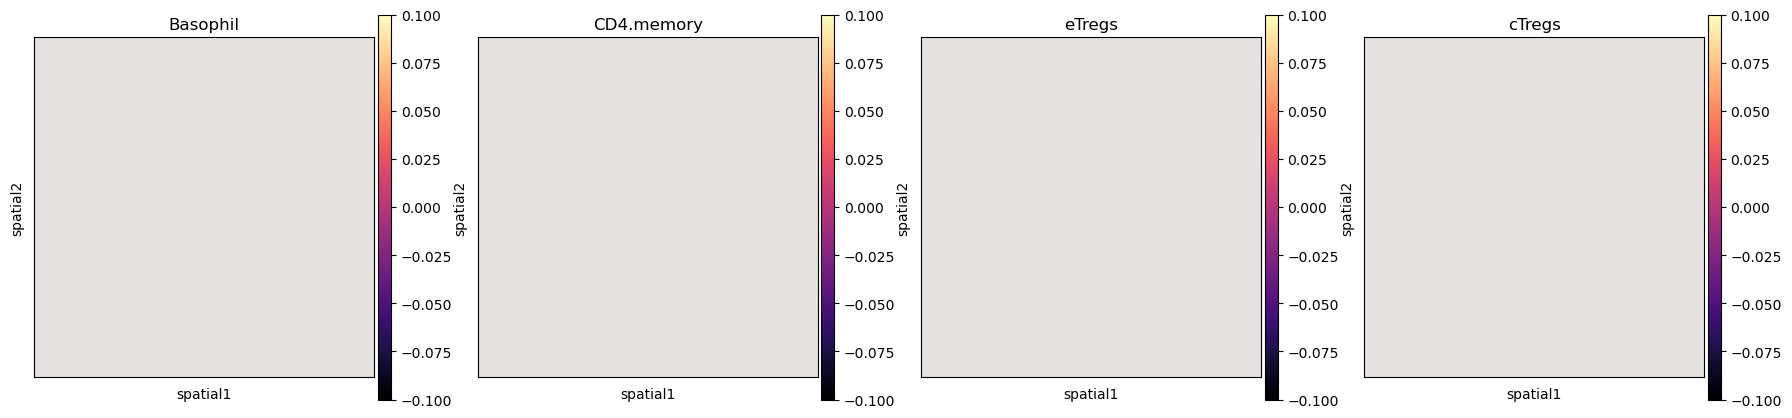

In [33]:
# select one slide
from cell2location.utils import select_slide
slide = select_slide(adata_vis, 'Mus_Tcel13255054')
    
# plot in spatial coordinates
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [4.5, 5]}):
    
    sc.pl.spatial(slide, cmap='magma',
                  # show first 8 cell types
                  color=['Basophil', 'CD4.memory','eTregs','cTregs'], 
                  ncols=4, size=1.3, 
                  img_key='hires',
                  # limit color scale at 99.2% quantile of cell abundance
                  vmin=0, vmax='p99.2' 
                 )

## Downstream analysis <a class="anchor" id="Downstream-analysis"></a>

### Identifying discrete tissue regions by Leiden clustering<a class="anchor" id="Identifying-discrete-tissue-regions-by-Leiden-clustering"></a>

We identify tissue regions that differ in their cell composition by clustering locations using cell abundance estimated by cell2location. 

We find tissue regions by clustering Visium spots using estimated cell abundance each cell type. We constuct a K-nearest neigbour (KNN) graph representing similarity of locations in estimated cell abundance and then apply Leiden clustering. The number of KNN neighbours should be adapted to size of dataset and the size of anatomically defined regions (e.i. hippocampus regions are rather small compared to size of the brain so could be masked by large `n_neighbors`). This can be done for a range KNN neighbours and Leiden clustering resolutions until a clustering matching the anatomical structure of the tissue is obtained. 

The clustering is done jointly across all Visium sections / batches, hence the region identities are directly comparable. When there are strong technical effects between multiple batches (not the case here) `sc.external.pp.bbknn` can be in principle used to account for those effects during the KNN construction.

The resulting clusters are saved in `adata_vis.obs['region_cluster']`.

In [34]:
# compute KNN using the cell2location output stored in adata.obsm
sc.pp.neighbors(adata_vis, use_rep='q05_cell_abundance_w_sf',
                n_neighbors = 15)

# Cluster spots into regions using scanpy
sc.tl.leiden(adata_vis, resolution=1.1)

# add region as categorical variable
adata_vis.obs["region_cluster"] = adata_vis.obs["leiden"].astype("category")

We can use the location composition similarity graph to build a joint integrated UMAP representation of all section/Visium batches.

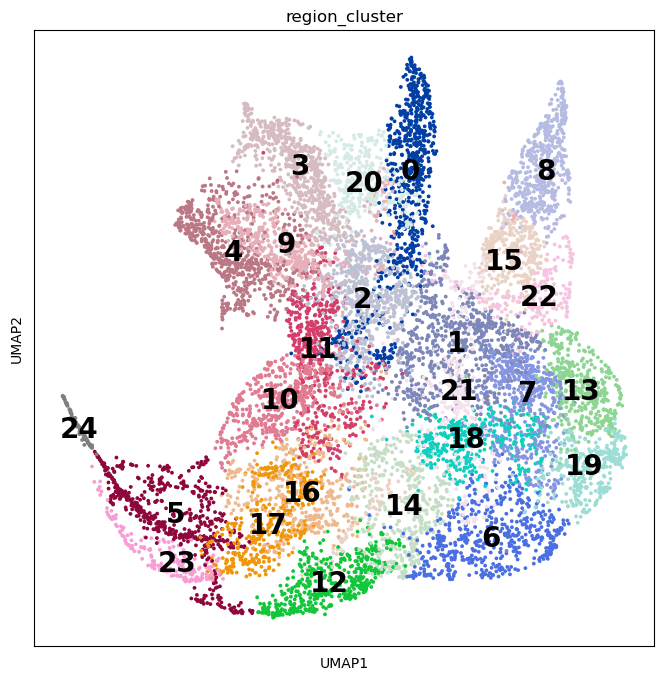

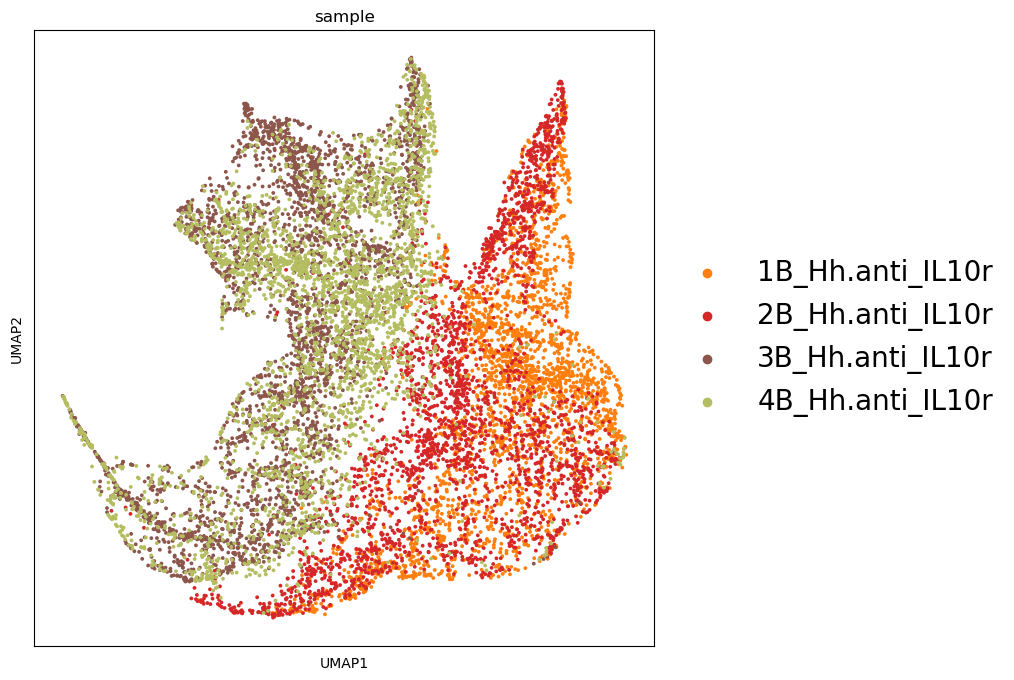

In [35]:
# compute UMAP using KNN graph based on the cell2location output
sc.tl.umap(adata_vis, min_dist = 0.3, spread = 1)

# show regions in UMAP coordinates
with mpl.rc_context({'axes.facecolor':  'white',
                     'figure.figsize': [8, 8]}):
    sc.pl.umap(adata_vis, color=['region_cluster'], size=30,
               color_map = 'RdPu', ncols = 2, legend_loc='on data',
               legend_fontsize=20)
    sc.pl.umap(adata_vis, color=['sample'], size=30,
               color_map = 'RdPu', ncols = 2,
               legend_fontsize=20)


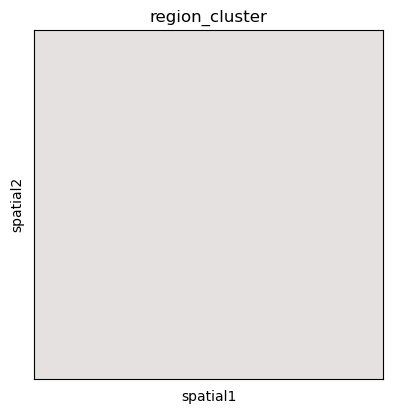

In [36]:
slide = select_slide(adata_vis, 'Mus_Tcel13255054')

with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [4.5, 5]}):
    sc.pl.spatial(slide, color=['region_cluster'], 
                  size=1.3, img_key='hires', alpha=0.5)

In [37]:
# Save anndata object with results
adata_vis.write(f"{run_name}/sp_Hh_antiIl10r.h5ad")

### Identifying cellular compartments / tissue zones using matrix factorisation (NMF) <a name="Identifying-cellular-compartments-/-tissue-zones-using-matrix-factorisation-(NMF)"></a>

Here, we use the cell2location mapping results to identify the spatial co-occurrence of cell types in order to better understand the tissue organisation and predict cellular interactions. We performed non-negative matrix factorization (NMF) of the cell type abundance estimates from cell2location ([paper section 4, Fig 4D](https://www.nature.com/articles/s41587-021-01139-4)). Similar to the established benefits of applying NMF to conventional scRNA-seq, the additive NMF decomposition yielded a grouping of spatial cell type abundance profiles into components that capture co-localised cell types ([Supplemenary Methods section 4.2, p. 60](https://www.nature.com/articles/s41587-021-01139-4#Sec50)). This NMF-based decomposition naturally accounts for the fact that multiple cell types and microenvironments can co-exist at the same Visium locations (see [paper Fig S20, p. 34](https://www.nature.com/articles/s41587-021-01139-4#Sec50)), while sharing information across tissue areas (e.g. individual germinal centres). 


<div class="alert alert-block alert-primary">
<b>Tip</b>
    
In practice, it is better to train NMF for a range of factors $R={5, .., 30}$ and select $R$ as a balance between capturing fine-grained and splitting known well-established tissue zones. 

If you want to find a few most disctinct cellular compartments, use a small number of factors.   
If you want to find very strong co-location signal and assume that most cell types don't co-locate, use a lot of factors (> 30 - used here).
</div>

Below we show how to perform this analysis. To aid this analysis, we wrapped the analysis shown the notebook on advanced downstream analysis into a pipeline that automates training of the NMF model with varying number of factors:

In [5]:
adata_vis=sc.read(f"{run_name}/sp_Hh_antiIl10r.h5ad")

In [6]:
adata_vis

AnnData object with n_obs × n_vars = 11602 × 11926
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'Sanger_ID', 'library_id', 'Slide_ID', 'Slide', 'Capture_area', 'Mouse', 'Conditions', 'n_counts', '_indices', '_scvi_batch', '_scvi_labels', 'Basophil', 'CD4.memory', 'DC1.Cd8+Xcr1+', 'DC.Il1b_high.Cd103+', 'DC.Il1b_high.Cd103+Sirpa+', 'DC.Il1b_low.Cd103-Sirpa+', 'DC.Sirpa+Cd81+', 'DC.prolif.', 'Endothelial.cells', 'Enteric_neurons', 'Enterocyte', 'Enterocyte.Progenitor', 'Enteroendocrine', 'Epithelial', 'Epithelial.MHCII+', 'Fibroblast.Adamdec1+Pdgfra_high', 'Fibroblast_Acta2+', 'Fibroblast_Adamdec1+Pdgfra_low', 'Fibroblast_Cxcl12+', 'Fibroblast_Endosialin+', 'GC.BC_DZ-pre-memory BC', 'GC_B.cell', 'Glial cells', 'Goblet', 'ILC2s', 'ILC3s.Rorgt+', 'ILC3s.Rorgt+.

In [ ]:
from cell2location import run_colocation
res_dict, adata_vis = run_colocation(
    adata_vis, 
    model_name='CoLocatedGroupsSklearnNMF',
    train_args={
      'n_fact': np.arange(5, 30), # IMPORTANT: use a wider range of the number of factors (5-30)
      'n_iter': 20000, # maximum number of training iterations
      'sample_name_col': 'Sanger_ID', # columns in adata_vis.obs that identifies sample           
      'n_restarts': 5 # number of training restarts
    },
    # the hyperparameters of NMF can be also adjusted:
    model_kwargs={'alpha': 0.01, 'init': 'random', "nmf_kwd_args": {"tol": 0.000001}},
    export_args={'path': f'{run_name}/CoLocatedComb_Hh_antiIl10r_30_fact/'}
) 

### Analysis name: CoLocatedGroupsSklearnNMF_20combinations_11602locations_63factors


/opt/conda/envs/cell2loc_env/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1425: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  FutureWarning,
/opt/conda/envs/cell2loc_env/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 20000 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/conda/envs/cell2loc_env/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1425: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  FutureWarning,
/opt/conda/envs/cell2loc_env/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 20000 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/conda/envs/cell2loc_env/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1425: FutureWarning: `alpha` 

### Analysis name: CoLocatedGroupsSklearnNMF_21combinations_11602locations_63factors


/opt/conda/envs/cell2loc_env/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1425: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  FutureWarning,
/opt/conda/envs/cell2loc_env/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 20000 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/conda/envs/cell2loc_env/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1425: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  FutureWarning,
/opt/conda/envs/cell2loc_env/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 20000 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/conda/envs/cell2loc_env/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1425: FutureWarning: `alpha` 

### Analysis name: CoLocatedGroupsSklearnNMF_22combinations_11602locations_63factors


/opt/conda/envs/cell2loc_env/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1425: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  FutureWarning,
/opt/conda/envs/cell2loc_env/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 20000 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/conda/envs/cell2loc_env/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1425: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  FutureWarning,
/opt/conda/envs/cell2loc_env/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 20000 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/conda/envs/cell2loc_env/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1425: FutureWarning: `alpha` 

### Analysis name: CoLocatedGroupsSklearnNMF_23combinations_11602locations_63factors


/opt/conda/envs/cell2loc_env/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1425: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  FutureWarning,
/opt/conda/envs/cell2loc_env/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 20000 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/conda/envs/cell2loc_env/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1425: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  FutureWarning,
/opt/conda/envs/cell2loc_env/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 20000 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/conda/envs/cell2loc_env/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1425: FutureWarning: `alpha` 

### Analysis name: CoLocatedGroupsSklearnNMF_24combinations_11602locations_63factors


/opt/conda/envs/cell2loc_env/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1425: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  FutureWarning,
/opt/conda/envs/cell2loc_env/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 20000 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/conda/envs/cell2loc_env/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1425: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  FutureWarning,
/opt/conda/envs/cell2loc_env/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 20000 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/conda/envs/cell2loc_env/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1425: FutureWarning: `alpha` 

### Analysis name: CoLocatedGroupsSklearnNMF_25combinations_11602locations_63factors


/opt/conda/envs/cell2loc_env/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1425: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  FutureWarning,
/opt/conda/envs/cell2loc_env/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 20000 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/conda/envs/cell2loc_env/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1425: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  FutureWarning,
/opt/conda/envs/cell2loc_env/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 20000 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/conda/envs/cell2loc_env/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1425: FutureWarning: `alpha` 

### Analysis name: CoLocatedGroupsSklearnNMF_26combinations_11602locations_63factors


/opt/conda/envs/cell2loc_env/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1425: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  FutureWarning,
/opt/conda/envs/cell2loc_env/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 20000 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/conda/envs/cell2loc_env/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1425: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  FutureWarning,
/opt/conda/envs/cell2loc_env/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 20000 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/conda/envs/cell2loc_env/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1425: FutureWarning: `alpha` 

### Analysis name: CoLocatedGroupsSklearnNMF_27combinations_11602locations_63factors


/opt/conda/envs/cell2loc_env/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1425: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  FutureWarning,
/opt/conda/envs/cell2loc_env/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 20000 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/conda/envs/cell2loc_env/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1425: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  FutureWarning,
/opt/conda/envs/cell2loc_env/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 20000 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/conda/envs/cell2loc_env/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1425: FutureWarning: `alpha` 

For every factor number, the model produces the following list of folder outputs:

`cell_type_fractions_heatmap/`: a dot plot of the estimated NMF weights of cell types (rows) across NMF components (columns)

`cell_type_fractions_mean/`: the data used for dot plot

`factor_markers/`: tables listing top 10 cell types most speficic to each NMF factor

`models/`: saved NMF models

`predictive_accuracy/`: 2D histogram plot showing how well NMF explains cell2location output

`spatial/`: NMF weights across locatinos in spatial coordinates

`location_factors_mean/`: the data used for the plot in spatial coordiantes

`stability_plots/`: stability of NMF weights between training restarts

Key output that you want to examine are the files in `cell_type_fractions_heatmap/` which show a dot plot of the estimated NMF weights of cell types (rows) across NMF components (columns) which correspond to cellular compartments. Shown are relative weights, normalized across components for every cell type.

<div class="alert alert-block alert-primary">
<b>Tip</b>
    
The NMF model output such as factor loadings are stored in `adata.uns[f"mod_coloc_n_fact{n_fact}"]` in a similar output format as main cell2location results in `adata.uns['mod']`.
</div>

In [ ]:
#adata_vis=sc.read(f"{run_name}/sp_Hh_antiIl10r.h5ad")

In [ ]:
adata_vis

In [ ]:
# Here we plot the NMF weights (Same as saved to `cell_type_fractions_heatmap`)
res_dict['n_fact30']['mod'].plot_cell_type_loadings()

### Estimate cell-type specific expression of every gene in the spatial data (needed for NCEM) <a name="Estimate-cell-type-specific-expression-of-every-gene-in-the-spatial-data-(needed-for-NCEM)"></a>

The cell-type specific expression of every gene at every spatial location in the spatial data enables learning cell communication with NCEM model using Visium data (https://github.com/theislab/ncem). 

To derive this, we adapt the approach of estimating conditional expected expression proposed by [RCTD (Cable et al)](https://pubmed.ncbi.nlm.nih.gov/33603203/) method. 

With cell2location, we can look at the posterior distribution rather than just point estimates of cell type specific expression (see `mod.samples.keys()` and next section on using full distribution).

Note that this analysis requires substantial amount of RAM memory and thefore doesn't work on free Google Colab (12 GB limit).

In [ ]:
# Compute expected expression per cell type
expected_dict = mod.module.model.compute_expected_per_cell_type(
    mod.samples["post_sample_q05"], mod.adata_manager
)

# Add to anndata layers
for i, n in enumerate(mod.factor_names_):
    adata_vis.layers[n] = expected_dict['mu'][i]

# Save anndata object with results
adata_file = f"{run_name}/sp_Hh_antiIl10r_NCEM.h5ad"
adata_vis.write(adata_file)
adata_file

<div class="alert alert-block alert-primary">
<b>Plotting cell-type specific expression of genes in spatial coordinates.</b>
    
Below we plot the cell-type specific expression of genes (rows, second to last columns) compared to total expression of those genes (first column).

Here we highlight *CD3D*, pan T-cell marker expressed by 2 subtypes of T cells in distinct locations but not expressed by co-located B cells, that instead express *CR2* gene.
</div>

In [ ]:
# list cell types and genes for plotting
ctypes = ['CD4.memory','eTregs','cTregs']
genes = ['Cd3e', 'Foxp3']

with mpl.rc_context({'axes.facecolor':  'black'}):
    # select one slide
    slide = select_slide(adata_vis, 'Mus_Tcel13255053')
    
    from tutorial_utils import plot_genes_per_cell_type
    plot_genes_per_cell_type(slide, genes, ctypes);

Note that `plot_genes_per_cell_type` function often need customization so it is not included into cell2location package - you need to copy it from https://github.com/BayraktarLab/cell2location/blob/master/docs/notebooks/tutorial_utils.py to use on your system.

### Modules and their versions used for this analysis


Useful for debugging and reporting issues.

In [ ]:
cell2location.utils.list_imported_modules()

In [ ]:
cell2location.__version__